In [1]:
%matplotlib inline
import os
os.environ["THEANO_FLAGS"] = "device=gpu"
import theano
from caffezoo.googlenet import GoogleNet
from caffezoo.vgg import VGG
from skimage.io import imread
from skimage.transform import AffineTransform, resize, SimilarityTransform, warp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from skimage.util import pad
from sklearn.cross_validation import cross_val_score

Using gpu device 0: Tesla K20Xm (CNMeM is disabled)
/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

def predictability_score(model, X, y):
    s = 0
    y_hat = model.predict(X)
    for i in range(y.shape[1]):
        s += explained_variance_score(y[:, i], y_hat[:, i])
    return s

def predictability(model, X, Y, cv=5):
    return cross_val_score(model, X, y, predictability_score, cv=cv)

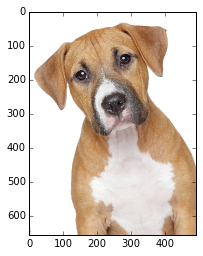

In [4]:
images = [
    imread('dog_PNG178.png'),
    imread('forest.jpg'),
    #imread('image1.jpg'),
    #imread('image2.jpg')
]

#nb = 100
#for i in range(1, nb+1):
#    images.append(imread('video/kiss/folder/{0:05d}.png'.format(i)))

image_name = {0: "dog", 1: "cat"}
#image_name = {
#    0:"circle",
#}
#image_name = {i: i for i in range(nb)}
plt.imshow(images[0])

In [5]:
def concat(layers):
    layers = [layer.reshape((layer.shape[0], np.prod(layer.shape[1:]))) for layer in layers]
    return np.concatenate(layers, axis=1)

def gram_matrix(x):
    g = (x[:, :, None, :, :] * x[:, None, :, :, :]).sum(axis=(3, 4))
    return g.reshape((x.shape[0],-1))
    #x = x.reshape((x.shape[0], x.shape[1], -1))
    #g = np.tensordot(x, x, axes=([2], [2]))
    #return g

def reduce_dim(f, dropout=0.5, seed=1234):
    def f_(layers):
        rng = np.random.RandomState(seed)
        layers = [
            l[:, (rng.uniform(size=l.shape[1]) > dropout)] for l in layers
        ]
        return f(layers)
    return f_
def gram(layers):
    layers = [
        gram_matrix(layer) for layer in layers
    ]
    return concat(layers)
def as_is(layers):
    return layers[0]

In [6]:
# rescale to (w, h)
w, h = 224, 224
images = [resize(im, (w, h), preserve_range=True) for im in images]

In [7]:
def without_alpha(I):
    if I.shape[2] == 4:
        return I[:, :, 0:3]
    return I


def translate(I, shift, direction='x', cval=0):
    new_I = np.zeros(I.shape)
    new_I += cval
    w = I.shape[0]
    if shift < 0:
        shift = -shift
        new_I[:, 0:w - shift, :] = I[:, shift:w, :]
    else:
        new_I[:, shift:w, :] = I[:, 0:w-shift, :]
    return new_I
    if direction == 'x':
        D = (shift, 0)
    elif direction == 'y':
        D = (0, shift)
    tform = SimilarityTransform(translation=D)
    warped = warp(I, tform, mode='constant', cval=cval)
    return warped

def blit(image):
    def f(I):
        if I.shape[2] == 3:
            o = image
        elif I.shape[2] == 4:
            alpha = I[:, :, 3]
            p = alpha / alpha.max()
            p = p[:, :, None]
            o = I[:, :, 0:3] * p + image * (1 - p)
        return o
    f.__name__ = "occlude"
    return f

def rotate(I, angle):
    tform = AffineTransform(rotation=angle)
    warped = warp(I, tform, cval=1.)
    return warped

def nothing(I):
    return I

def pipeline(L):
    def f(I, params):
        for i, l in enumerate(L):
            I = l(I, *params[i])
        return I
    f.__name__ = "pipeline"
    return f

def is_sequence(arg):
    return (not hasattr(arg, "strip") and
            hasattr(arg, "__getitem__") or
            hasattr(arg, "__iter__"))

def for_all(images, transformation, params):
    if not is_sequence(params):
        params = [params]
    for image in images:        
        image = transformation(image, *params)
        yield image

def generate_all(images, transformation, params_list):
    for param in params_list:
        for i, image in enumerate(for_all(images, transformation, param)):
            yield i, image, param

def build_pipeline_params(all_params):
    min_len = min(len(p) for p in all_params if p is not None)
    all_params_cleaned = []
    for p in all_params:
        if p is None:
            p = [[]] * min_len
        else:
            p = [ap if is_sequence(ap) else [ap] for ap in p]
        all_params_cleaned.append(p)
    all_params_cleaned =  [ap for ap in zip(*all_params_cleaned)]
    all_params_cleaned = [ [ap] for ap in all_params_cleaned]
    return all_params_cleaned

In [8]:

#params_list = (np.linspace(-np.pi/6, np.pi/6, 200)).tolist() 
params_list = np.arange(-100, 100).tolist()
all_params_list = build_pipeline_params([params_list, None])
#all_params_list = params_list
T = pipeline([
     translate, 
     blit(images[1])
])
#T = translate

#T = translate
generator = generate_all

transformed_images = []
labels = []
indices = []
for image_index, image, param in generator(images, T, all_params_list):
    transformed_images.append(image)
    labels.append(param)
    indices.append(image_index)
transformed_images = (np.array(transformed_images))
indices = np.array(indices)
labels = np.array(labels)

In [ ]:
#plt.imshow(translate(images[0], -100, cval=1))
#plt.imshow(images[0])
#print(images[0][0:223])
#print(translate(images[0], 1, cval=255))
plt.clf()
plt.imshow(transformed_images[0].astype(np.uint8))
plt.show()
plt.clf()
plt.imshow(transformed_images[1].astype(np.uint8))
plt.show()
print((transformed_images_[2, :, 0:223, :]-transformed_images_[3, :, 1:224,]).sum())

In [ ]:
print(transformed_images.shape)

In [ ]:
plt.imshow(transformed_images[100].astype(np.uint8))

In [ ]:
L = [ "input",
      "conv2/3x3_reduce",
     "inception_3a/output", "inception_3b/output", 
     "inception_4a/output", "inception_4b/output",
     "inception_4c/output", "inception_4d/output",
     "inception_4e/output", "inception_5a/output",
     "inception_5b/output", "inception_5b/output", "pool5/7x7_s1"]
layers = [L[1]]
model = GoogleNet(resize=False, 
                  layer_names=layers, 
                  aggregate_function=concat, 
                  batch_size=50)
model._load()

In [ ]:
h = model.transform(transformed_images)
print(h.shape)

In [ ]:
dimrec = PCA(n_components=2)
dimrec.fit((h[np.abs(params_list<=50)]))
h_ = dimrec.fit_transform(h)
h_per_class = []
for  i in range(len(images)):
    v = (indices==i)
    h_per_class.append(clone(dimrec).fit_transform(h[v]))
#dimrec.explained_variance_ratio_

In [ ]:
colors = ['red', 'blue']
annotate = False
for i, h_class in enumerate(h_per_class):
    plt.subplot(1, len(h_per_class), i + 1)
    plt.scatter(h_class[:, 0], h_class[:, 1],s=10,c=colors[i])
    plt.title(image_name[i])
    if annotate is True:
        for k, param in enumerate(np.array(labels)[np.array(indices)==i]):
            plt.annotate(str(param),
                        xy=(h_class[k, 0], h_class[k, 1]),  # theta, radius
                        xytext=(h_class[k, 0], 
                                h_class[k, 1]+np.abs(h_class[k, 1])*0))
filename = T.__name__ + "_"+"-".join(layers).replace("/","-")+".png"
print(filename)
plt.savefig(filename)
plt.show()

In [ ]:
plt.scatter(h_[:, 0], h_[:, 1], c=np.array(["red", "blue"])[np.array(indices)],s=20)
if annotate is True:
    for i, param in enumerate(labels):
        plt.annotate(str(param),
                    xy=(h_[i, 0], h_[i, 1]),  # theta, radius
                    xytext=(h_[i, 0], h_[i, 1]))

In [ ]:
print((transformed_images[0, :, 0:223, :]-transformed_images[2, :, 1:224,]).sum())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import matplotlib.animation as animation
ind = 0
h__ = h_per_class[ind]
transformed_images_ = transformed_images[indices==ind]
print(h__.shape)
plt.clf()

# This example uses subclassing, but there is no reason that the proper
# function couldn't be set up and then use FuncAnimation. The code is long, but
# not really complex. The length is due solely to the fact that there are a
# total of 9 lines that need to be changed for the animation as well as 3
# subplots that need initial set up.
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        
        #self.img1 = ax1.imshow(np.random.uniform(h_.min(), h_.max(), (W, H)), 
        #                       vmin=-1, vmax=1, cmap=test_cm, interpolation='none',
        #                       label="title")
        self.plot1 = ax1.scatter(h__[:, 0], h__[:, 1])
        self.img2 = ax2.imshow(np.random.uniform(h_.min(), h_.max(), (W, H)), 
                               vmin=-1, vmax=1, cmap=test_cm, interpolation='none',
                               label="title")
        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        #self.img1.set_data( (h_[i, :]).reshape((W, H)))
        #self.plot1.set_data( h__[:, 0] , h__[:, 1] )
        #self.plot1.set_offsets(h__[:, 0:2].T)
        #self.plot1.set_array(h__[:, 1])
        
        c = ['blue'] * len(h__)
        c[i] = 'red'
        self.plot1.set_color(c)
        s = [5] * len(h__)
        s[i] = 5
        self.plot1.set_sizes(s)
        zorder = [2] * len(h__)
        zorder[i] = 1
        self.plot1.set_zorder(zorder)
        #self.img2.set_data( (h_[i, :]).reshape((W, H)))
        self.img2.set_data(  transformed_images_[i].astype(np.uint8) )
        self._drawn_artists = [self.plot1, self.img2]

    def new_frame_seq(self):
        return iter(range(h__.shape[0]))

    def _init_draw(self):
         pass
ani = SubplotAnimation()
ani.save('test_sub.mp4', fps=10)
plt.show()

In [ ]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
%matplotlib inline
import numpy as np
from colormap import test_cm
from matplotlib import pyplot as plt
from matplotlib import animation
ind = 0
labels_ = labels[indices==ind]
#h_ = PCA(n_components=20).fit_transform(h)
#h_ = PCA(n_components=40).fit_transform(h[indices==ind])

#h_  = h[indices==ind].copy()
h_ = h.copy()

#s = np.random.randint(0, h_.shape[1], size=400)
#h_  = h_[:, s]


#h_ = (h_ - h_.min(axis=0)) / (h_.max(axis=0) - h_.min(axis=0))
print(h_.shape)
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()

#ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
ax = plt.axes()

for e in range(int(np.sqrt(h_.shape[1])), 1, -1):
    if (h_.shape[1] % e) == 0:
        W = e
        break

H = h_.shape[1] / W
print(h_.min(), h_.max())
img = ax.imshow(np.random.uniform(h_.min(), h_.max(), (W, H)), 
                vmin=-1, vmax=1, cmap=test_cm, interpolation='none',
                label="title")

# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    img.set_data(h_[0, :].reshape((W, H)))
    return img

# animation function.  This is called sequentially
def animate(i):
    img.set_data( (h_[i, :]).reshape((W, H)))
    img.set_label("title")
    #plt.title(str(labels_[i]))
    return img

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=h_.shape[0]-1, interval=100, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

anim.save('basic_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
plt.show()

### convnet vis

In [ ]:
L = [ "input",
      "conv2/3x3_reduce",
     "inception_3a/output", "inception_3b/output", 
     "inception_4a/output", "inception_4b/output",
     "inception_4c/output", "inception_4d/output",
     "inception_4e/output", "inception_5a/output",
     "inception_5b/output", "inception_5b/output", "pool5/7x7_s1"]
layers = [L[5]]
model = GoogleNet(resize=False, 
                  layer_names=layers, 
                  aggregate_function=as_is, 
                  batch_size=50)
model._load()

In [ ]:
h = model.transform(transformed_images)
print(h.shape)

In [ ]:
nb = 10
k = 1
fig = plt.figure(figsize=(20, 20))
filter_nb = 3
for i in np.linspace(0, 100, 10):
    plt.subplot(nb, 2, k)
    plt.imshow(transformed_images[indices==0][i].astype(np.uint8))
    plt.axis('off')
    k += 1
    plt.subplot(nb, 2, k)
    plt.imshow((h[indices==0][i, filter_nb]), cmap="cool", interpolation='none')
    plt.axis('off')
    k += 1
plt.tight_layout(pad=0., w_pad=0, h_pad=0)
plt.show()